In [2]:
import sys, os
import pandas as pd
import numpy as np

print("Python:", sys.version)
print("Current working directory:", os.getcwd())
print("Packages OK")


Python: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
Current working directory: c:\Users\EL11\projects-semicon\azure-semicon
Packages OK


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
print("OK")

OK


In [4]:
import pandas as pd
from pathlib import Path

# 1) 경로 설정
raw_data_path = Path(r"C:\Users\EL11\projects-semicon\azure-semicon\data\raw_data\secom.data")
label_data_path = Path(r"C:\Users\EL11\projects-semicon\azure-semicon\data\raw_data\secom_labels.data")
output_path = Path(r"C:\Users\EL11\projects-semicon\azure-semicon\data\processed\secom_named.csv")

# 2) 원본 데이터 읽기 (공백 여러 개 구분)
df = pd.read_csv(raw_data_path, sep=r"\s+", header=None)

# 3) 센서 컬럼명 붙이기
df.columns = [f"sensor_{i+1}" for i in range(df.shape[1])]

# 4) 라벨 파일 읽기
labels = pd.read_csv(label_data_path, sep=r"\s+", header=None)
# secom_labels.data는 [label, timestamp] 순서임
labels.columns = ["label", "timestamp"]

# 5) 원본 데이터에 라벨/타임스탬프 붙이기
df["timestamp"] = labels["timestamp"]
df["label"] = labels["label"]

# 6) 저장 폴더 없으면 만들기
output_path.parent.mkdir(parents=True, exist_ok=True)

# 7) 처리된 데이터 저장 (원본은 따로)
df.to_csv(output_path, index=False)

# 8) 확인용 출력
print("저장됨:", output_path)
print("shape:", df.shape)
print("라벨 분포:\n", df["label"].value_counts())


저장됨: C:\Users\EL11\projects-semicon\azure-semicon\data\processed\secom_named.csv
shape: (1567, 592)
라벨 분포:
 label
-1    1463
 1     104
Name: count, dtype: int64


(1567, 592)
label
-1    1463
 1     104
Name: count, dtype: int64


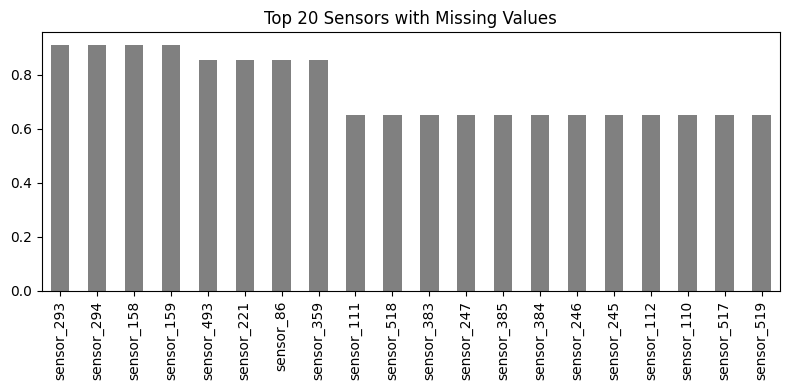

C:\Users\EL11\AppData\Local\Temp\ipykernel_21192\807958079.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df, palette="coolwarm")


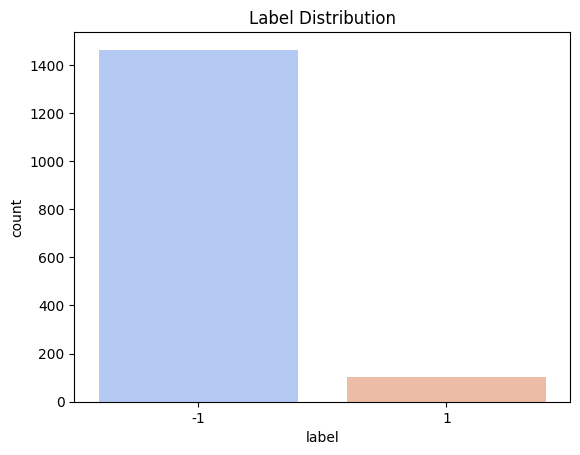

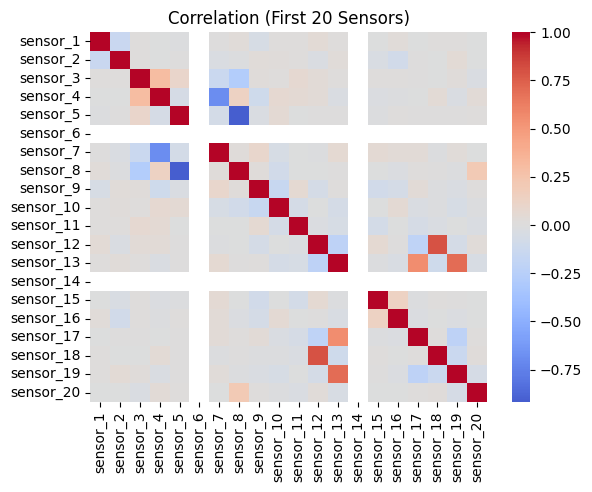

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

print(df.shape)
print(df["label"].value_counts())

# 결측 비율 시각화
missing = df.isna().mean().sort_values(ascending=False).head(20)
missing.plot(kind="bar", figsize=(8,4), color="gray")
plt.title("Top 20 Sensors with Missing Values")
plt.tight_layout()
plt.show()

# 라벨 분포
sns.countplot(x="label", data=df, palette="coolwarm")
plt.title("Label Distribution")
plt.show()

# 상관계수 히트맵 (일부)
sns.heatmap(df.iloc[:, :20].corr(), cmap="coolwarm", center=0)
plt.title("Correlation (First 20 Sensors)")
plt.show()


In [6]:
import pandas as pd
import numpy as np

# 결측 여부를 0/1로 변환
missing_flag = df.isna().astype(int)

# 라벨(불량 여부) 붙이기
missing_flag["label"] = df["label"]

# 각 센서별로 불량 시 결측 비율 계산
corr_list = []
for col in df.columns[:-2]:  # timestamp, label 제외
    fail_rate = missing_flag.groupby("label")[col].mean()
    corr_list.append((col, fail_rate.get(1, 0), fail_rate.get(-1, 0)))

corr_df = pd.DataFrame(corr_list, columns=["sensor", "missing_rate_fail", "missing_rate_normal"])
corr_df["diff"] = corr_df["missing_rate_fail"] - corr_df["missing_rate_normal"]
corr_df.sort_values("diff", ascending=False).head(10)


,sensor,missing_rate_fail,missing_rate_normal,diff
517,sensor_518,0.711538,0.645249,0.066289
516,sensor_517,0.711538,0.645249,0.066289
518,sensor_519,0.711538,0.645249,0.066289
246,sensor_247,0.711538,0.645249,0.066289
244,sensor_245,0.711538,0.645249,0.066289
382,sensor_383,0.711538,0.645249,0.066289
383,sensor_384,0.711538,0.645249,0.066289
111,sensor_112,0.711538,0.645249,0.066289
110,sensor_111,0.711538,0.645249,0.066289
109,sensor_110,0.711538,0.645249,0.066289


Text(0.5, 1.0, 'Samples Missing Count by Label')

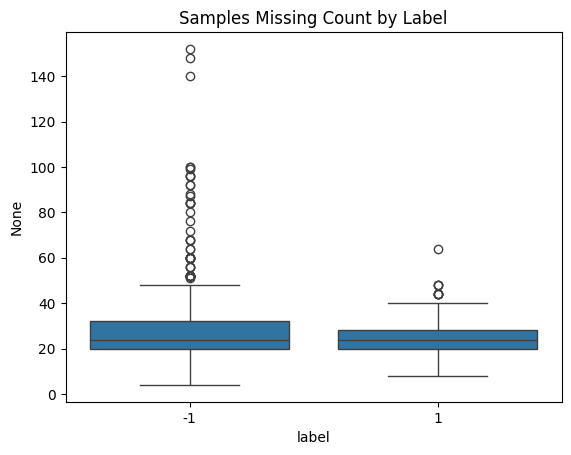

In [7]:
sns.boxplot(x="label", y=df.isna().sum(axis=1), data=df)
plt.title("Samples Missing Count by Label")


In [8]:
df["missing_ratio"] = df.isna().mean(axis=1)


센서 개수: 590


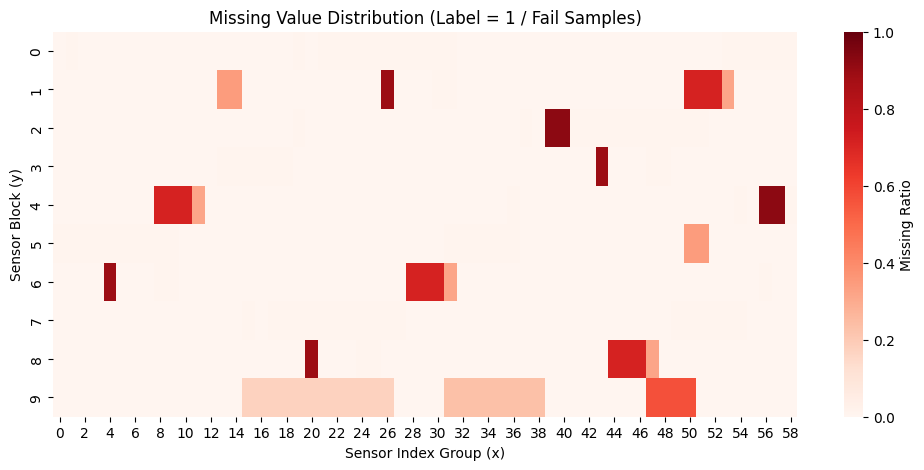

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# sensor 컬럼만 추출
sensor_cols = [c for c in df.columns if c.startswith("sensor_")]

# 불량 샘플 중 센서 결측 비율 계산 (길이 = 590)
missing_fail = df.loc[df["label"] == 1, sensor_cols].isna().mean()

print("센서 개수:", len(missing_fail))  # 꼭 찍어서 확인해보자 (590이면 정상)

# 10x59 배열로 변환
heat_data = missing_fail.values.reshape(10, 59)

# 시각화
plt.figure(figsize=(12, 5))
sns.heatmap(heat_data, cmap="Reds", vmin=0, vmax=1, cbar_kws={"label": "Missing Ratio"})
plt.title("Missing Value Distribution (Label = 1 / Fail Samples)")
plt.xlabel("Sensor Index Group (x)")
plt.ylabel("Sensor Block (y)")
plt.show()


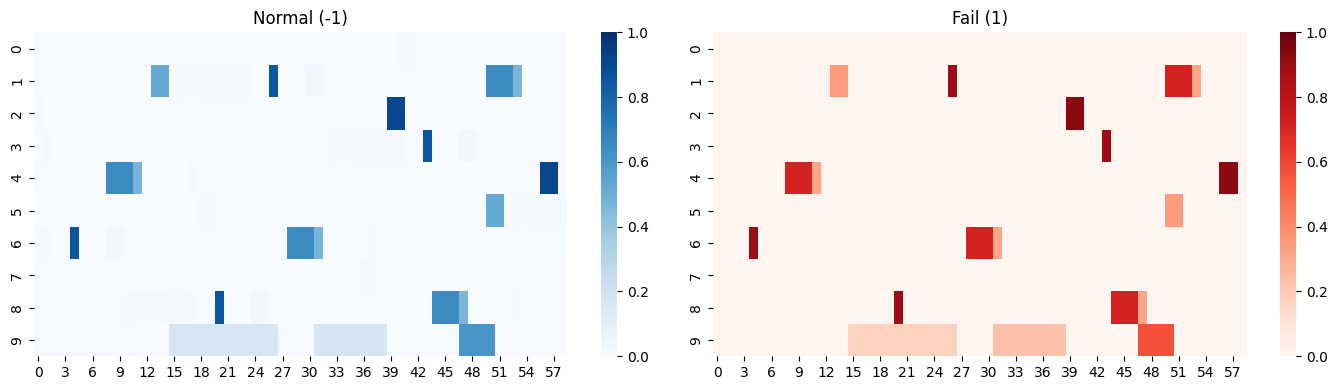

In [10]:
missing_normal = df.loc[df["label"] == -1, sensor_cols].isna().mean()
heat_data_normal = missing_normal.values.reshape(10, 59)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.heatmap(heat_data_normal, cmap="Blues", vmin=0, vmax=1, ax=axes[0])
sns.heatmap(heat_data, cmap="Reds", vmin=0, vmax=1, ax=axes[1])
axes[0].set_title("Normal (-1)")
axes[1].set_title("Fail (1)")
plt.tight_layout()
plt.show()


In [11]:
diffs = (df[df["label"]==1][sensor_cols].isna().mean() -
         df[df["label"]==-1][sensor_cols].isna().mean())

print("불량 - 정상 결측률 차이 평균:", diffs.mean())
print("차이가 0.05 이상인 센서 수:", (abs(diffs) > 0.05).sum())

불량 - 정상 결측률 차이 평균: -0.002378174902706569
차이가 0.05 이상인 센서 수: 28


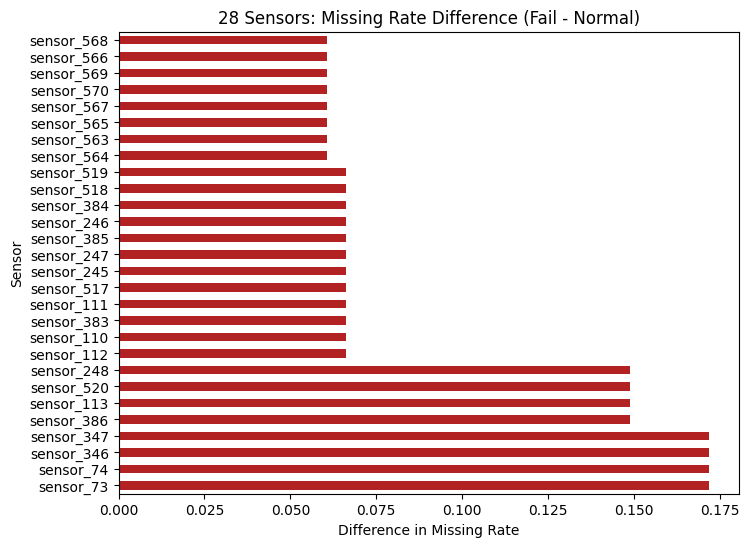

In [12]:
top_diff = diffs.abs().sort_values(ascending=False).head(28)
plt.figure(figsize=(8,6))
top_diff.plot(kind="barh", color="firebrick")
plt.title("28 Sensors: Missing Rate Difference (Fail - Normal)")
plt.xlabel("Difference in Missing Rate")
plt.ylabel("Sensor")
plt.show()


In [13]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import BorderlineSMOTE

# 1) 데이터 불러오기
df = pd.read_csv(
    r"C:\Users\EL11\projects-semicon\azure-semicon\data\processed\secom_named.csv"
)

# 2) X, y 분리 (숫자 컬럼만)
sensor_cols = [c for c in df.columns if c.startswith("sensor_")]
X = df[sensor_cols].copy()
y = df["label"].copy()

# 3) NaN 처리 (SMOTE는 NaN 못 다룸)
#    여기서는 간단히 각 컬럼 평균으로 채움
X = X.fillna(X.mean())

# 4) 불량(1)만 골라서 노이즈 살짝 더하기
minority = X[y == 1].copy()
noise = np.random.normal(0, 0.01, size=minority.shape)  # 표준편차 0.01 정도
minority_aug = minority + noise

# 5) 원본 + 증량분 합치기
X_aug = pd.concat([X, minority_aug], ignore_index=True)
y_aug = pd.concat([y, pd.Series([1] * len(minority_aug))], ignore_index=True)

# 6) SMOTE (경계기반)
smote = BorderlineSMOTE(random_state=42, k_neighbors=5)
X_final, y_final = smote.fit_resample(X_aug, y_aug)

print("원래 라벨 분포:")
print(y.value_counts())
print("\n증량 후 라벨 분포:")
print(y_final.value_counts())


원래 라벨 분포:
label
-1    1463
 1     104
Name: count, dtype: int64

증량 후 라벨 분포:
-1    1463
 1    1463
Name: count, dtype: int64


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42, stratify=y_final)


In [15]:
print(X_train.shape, X_test.shape)


(2340, 590) (586, 590)


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

print(classification_report(y_test, pred))


              precision    recall  f1-score   support

          -1       0.89      1.00      0.94       293
           1       1.00      0.88      0.93       293

    accuracy                           0.94       586
   macro avg       0.95      0.94      0.94       586
weighted avg       0.95      0.94      0.94       586



<Figure size 400x400 with 0 Axes>

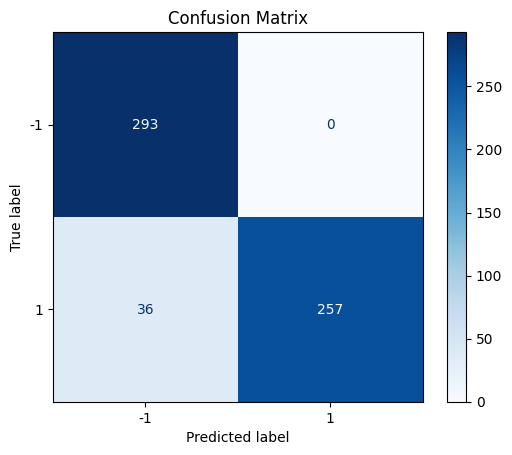

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=[-1, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])

plt.figure(figsize=(4,4))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [18]:
import pandas as pd

# X_train이랑 같은 순서의 컬럼 이름 필요
feature_names = X_train.columns

importances = rf.feature_importances_
fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print(fi.head(20))


        feature  importance
178  sensor_179    0.028078
243  sensor_244    0.027704
379  sensor_380    0.026810
149  sensor_150    0.021867
249  sensor_250    0.017722
236  sensor_237    0.016935
265  sensor_266    0.016219
402  sensor_403    0.014553
465  sensor_466    0.013921
450  sensor_451    0.012167
478  sensor_479    0.012042
509  sensor_510    0.011818
514  sensor_515    0.010777
226  sensor_227    0.010326
59    sensor_60    0.009513
503  sensor_504    0.009409
466  sensor_467    0.009270
371  sensor_372    0.008666
52    sensor_53    0.008535
141  sensor_142    0.008531


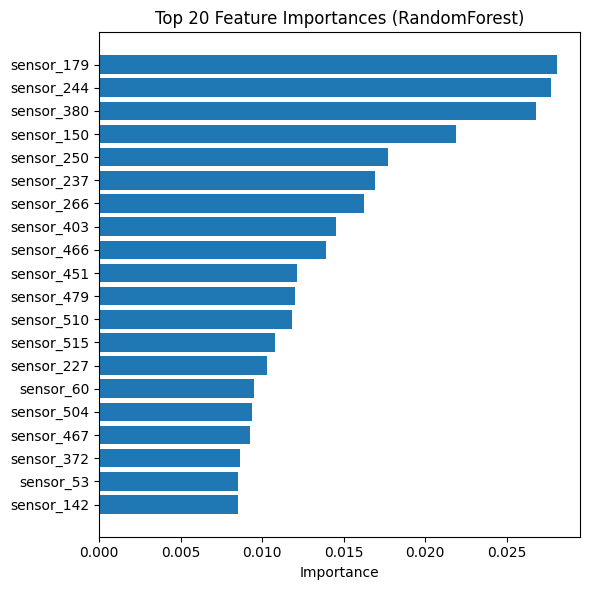

In [19]:
top_n = 20
fi_top = fi.head(top_n).sort_values("importance")  # 아래에서 위로

plt.figure(figsize=(6,6))
plt.barh(fi_top["feature"], fi_top["importance"])
plt.title("Top 20 Feature Importances (RandomForest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
import pandas as pd

# 데이터 준비 (이미 전처리 된 df)
X = df.filter(like="sensor_").select_dtypes(include=['number'])
X = X.fillna(X.mean())
y = df["label"].replace({-1: 0, 1: 1})

# 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [25]:
samplers = {
    "SMOTE": SMOTE(random_state=42),
    "ADASYN": ADASYN(random_state=42),
    "RandomOverSampler": RandomOverSampler(random_state=42)
}


In [26]:
results = []

for name, sampler in samplers.items():
    X_res, y_res = sampler.fit_resample(X_train, y_train)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_res, y_res)
    y_pred = model.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    results.append({
        "Method": name,
        "Accuracy": report["accuracy"],
        "Precision (불량)": report["1"]["precision"],
        "Recall (불량)": report["1"]["recall"],
        "F1 (불량)": report["1"]["f1-score"]
    })

df_result = pd.DataFrame(results)
df_result


c:\Users\EL11\projects-semicon\azure-semicon\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\EL11\projects-semicon\azure-semicon\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\EL11\projects-semicon\azure-semicon\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

,Method,Accuracy,Precision (불량),Recall (불량),F1 (불량)
0,SMOTE,0.933121,0.0,0.0,0.0
1,ADASYN,0.933121,0.0,0.0,0.0
2,RandomOverSampler,0.933121,0.0,0.0,0.0


In [27]:
print("원본 라벨 분포:\n", y_train.value_counts())
for name, sampler in samplers.items():
    X_res, y_res = sampler.fit_resample(X_train, y_train)
    print(f"{name} 후 라벨 분포:\n", y_res.value_counts(), "\n")


원본 라벨 분포:
 label
0    1170
1      83
Name: count, dtype: int64
SMOTE 후 라벨 분포:
 label
0    1170
1    1170
Name: count, dtype: int64 

ADASYN 후 라벨 분포:
 label
0    1170
1    1151
Name: count, dtype: int64 

RandomOverSampler 후 라벨 분포:
 label
0    1170
1    1170
Name: count, dtype: int64 



In [28]:
print("테스트셋 라벨 분포:\n", y_test.value_counts(normalize=True))

테스트셋 라벨 분포:
 label
0    0.933121
1    0.066879
Name: proportion, dtype: float64


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

imputers = {
    "Zero": SimpleImputer(strategy="constant", fill_value=0),
    "Mean": SimpleImputer(strategy="mean"),
    "Median": SimpleImputer(strategy="median")
}

results = []

# Train/Test 분리 (Stratify 유지)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

for name, imp in imputers.items():
    # 훈련셋 기준으로 fit_transform → 테스트셋은 transform만!
    X_train_imp = pd.DataFrame(imp.fit_transform(X_train), columns=X.columns)
    X_test_imp = pd.DataFrame(imp.transform(X_test), columns=X.columns)
    
    model = RandomForestClassifier(random_state=42, class_weight='balanced')
    model.fit(X_train_imp, y_train)
    y_pred = model.predict(X_test_imp)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    
    results.append({
        "Method": name,
        "Accuracy": report["accuracy"],
        "Precision(불량)": report["1"]["precision"],
        "Recall(불량)": report["1"]["recall"],
        "F1(불량)": report["1"]["f1-score"]
    })

pd.DataFrame(results)


c:\Users\EL11\projects-semicon\azure-semicon\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\EL11\projects-semicon\azure-semicon\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\EL11\projects-semicon\azure-semicon\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

,Method,Accuracy,Precision(불량),Recall(불량),F1(불량)
0,Zero,0.933121,0.0,0.0,0.0
1,Mean,0.933121,0.0,0.0,0.0
2,Median,0.933121,0.0,0.0,0.0


In [31]:
model = RandomForestClassifier(random_state=42, class_weight={0:1, 1:10})


In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

print("불량감지 3종 비교 baseline / class_weight / threshold 조정")
# baseline 모델
model_base = RandomForestClassifier(random_state=42)
model_base.fit(X_train_imp, y_train)
y_pred_base = model_base.predict(X_test_imp)

# class_weight 적용 모델
model_weighted = RandomForestClassifier(
    random_state=42,
    class_weight={0:1, 1:10}  # 불량(1)에 10배 가중치
)
model_weighted.fit(X_train_imp, y_train)
y_pred_weighted = model_weighted.predict(X_test_imp)

# threshold 조정 모델 (불량 확률 0.3 이상이면 불량으로 분류)
y_proba = model_weighted.predict_proba(X_test_imp)[:, 1]
y_pred_thresh = (y_proba > 0.3).astype(int)

# 결과 저장
results = []
for name, pred in zip(
    ["Baseline", "ClassWeight", "Threshold(0.3)"],
    [y_pred_base, y_pred_weighted, y_pred_thresh]
):
    report = classification_report(y_test, pred, output_dict=True)
    results.append({
        "Model": name,
        "Accuracy": report["accuracy"],
        "Precision(불량)": report["1"]["precision"],
        "Recall(불량)": report["1"]["recall"],
        "F1(불량)": report["1"]["f1-score"]
    })

results_df = pd.DataFrame(results)
display(results_df)


불량감지 3종 비교 baseline / class_weight / threshold 조정


c:\Users\EL11\projects-semicon\azure-semicon\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\EL11\projects-semicon\azure-semicon\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\EL11\projects-semicon\azure-semicon\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

,Model,Accuracy,Precision(불량),Recall(불량),F1(불량)
0,Baseline,0.933121,0.0,0.0,0.0
1,ClassWeight,0.933121,0.0,0.0,0.0
2,Threshold(0.3),0.933121,0.0,0.0,0.0
